# Stock Market Forecasting

In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import itertools
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")


In [36]:
ticker_symbol = "AMZN"
df = yf.download(ticker_symbol,start="2014-01-01", end="2024-03-21")
amzn_df = df

[*********************100%%**********************]  1 of 1 completed


In [37]:
amzn_df.head()


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.940001,19.9680,19.701000,19.898500,19.898500,42756000
2014-01-03,19.914499,20.1355,19.811001,19.822001,19.822001,44204000
2014-01-06,19.792500,19.8500,19.421000,19.681499,19.681499,63412000
2014-01-07,19.752001,19.9235,19.714500,19.901501,19.901501,38320000
2014-01-08,19.923500,20.1500,19.802000,20.096001,20.096001,46330000


## Data preprocessing

In [38]:
amzn_df = amzn_df.dropna()
amzn_df.head()
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
amzn_df.drop(cols, axis=1, inplace=True)

amzn_df.isnull().sum()


Close    0
dtype: int64

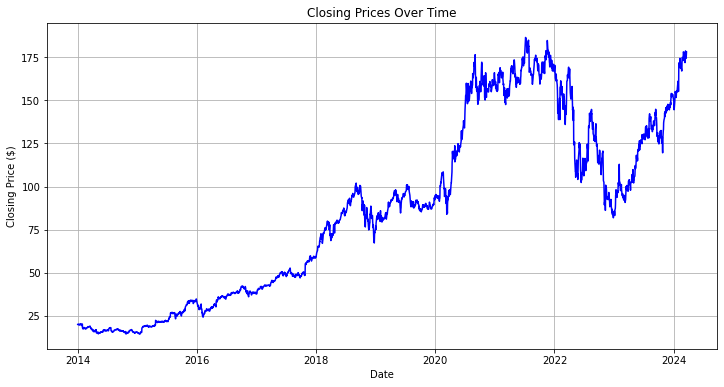

In [39]:
## visualization
plt.figure(figsize=(12, 6))
plt.plot(amzn_df['Close'], color='blue')
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

In [40]:
monthly_mean = amzn_df.Close.resample('M').mean()

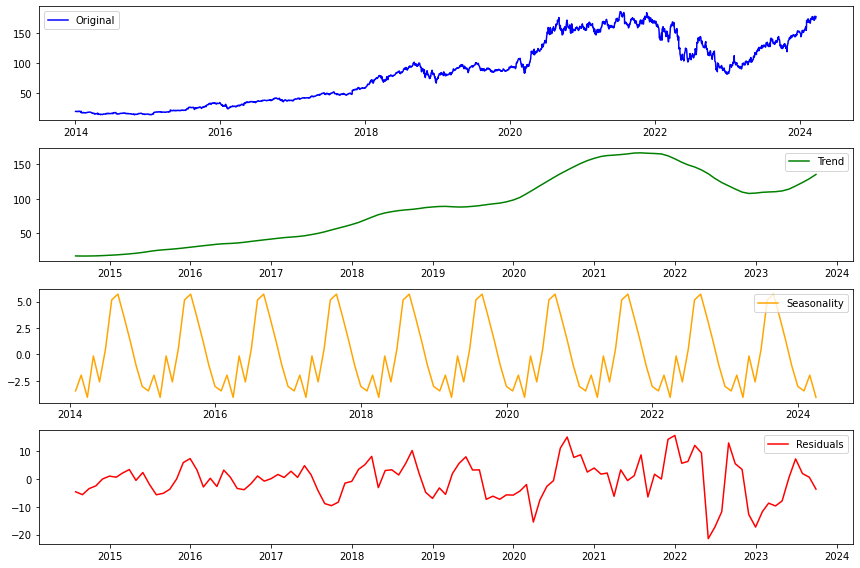

In [41]:
decomposition = seasonal_decompose(monthly_mean, model='additive')  # Assuming a periodicity of 30 for monthly data
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(amzn_df['Close'], label='Original', color='blue')
plt.legend(loc='best')

# Plot the trend component
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend', color='green')
plt.legend(loc='best')

# Plot the seasonal component
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonality', color='orange')
plt.legend(loc='best')

# Plot the residual component
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

# Detect anomalies


In [42]:
residuals_std = decomposition.resid.std()
anomalies = amzn_df[(amzn_df['Close'] - decomposition.trend) > 2 * residuals_std]
print("Anomalies:")
print(anomalies)

Anomalies:
                 Close
Date                  
2018-08-31  100.635498
2020-07-31  158.233994
2020-08-31  172.548004
2022-03-31  162.997498


# Summer stattistics

In [43]:
summary_stats = monthly_mean.describe()
print(summary_stats)

count    123.000000
mean      86.353626
std       52.407459
min       15.137375
25%       37.619818
50%       88.714701
75%      130.747637
max      180.800310
Name: Close, dtype: float64


# Perform Augmented Dickey-Fuller test

In [44]:
adf_result = adfuller(monthly_mean)
if adf_result[1] < 0.05:
    print("ADF test result: Time series is stationary.")
else:
    print("ADF test result: Time series is not stationary.")
    

ADF test result: Time series is not stationary.


### Apply differencing

In [45]:
monthly_mean_diff = monthly_mean.diff() # drop the first NaN value
adf_result_diff = adfuller(monthly_mean_diff.dropna())
if adf_result_diff[1] < 0.05:
    print("ADF test result: Time series is stationary after differencing.")
else:
    print("ADF test result: Time series is still not stationary after differencing.")


ADF test result: Time series is stationary after differencing.


# Time series forcasting Using SARIMA

In [46]:
train = monthly_mean[:'2021-12-31']
test = actual = monthly_mean['2021-12-31':]

In [47]:
p = d = q = range(0, 2)

In [48]:
# p = q = range(0,5)
# pdq_list = [(x[0],x[1],1)for x in list(itertools.product(p,q))]

In [49]:
pdq_list = list(itertools.product(p, d, q))

spdq_list = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq_list[1], spdq_list[1]))
print('SARIMAX: {} x {}'.format(pdq_list[1], spdq_list[2]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)


In [50]:

aic_dict = {}

for pdq in pdq_list:
    for spdq in spdq_list:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=pdq,
                                            seasonal_order=spdq,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            result_model = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(pdq, spdq, result_model.aic))
            aic_dict[(pdq, spdq)] = result_model.aic  # Corrected line
        except:
            continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.87031D+00    |proj g|=  1.09347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   3.197D-09   5.870D+00
  F =   5.8702810290472334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1129.0939575770687
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.13690D+00    |proj g|=  8.66489D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   8.665D-06   3.137D+00
  F =   3.1369044920936608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:608.2856624819829
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08977D+00    |proj g|=  5.96138D-01

At iterate    5    f=  4.76674D+00    |proj g|=  1.94448D-02

At iterate   1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.34782D+00    |proj g|=  2.12626D-02

At iterate   10    f=  3.23298D+00    |proj g|=  1.39725D-01

At iterate   15    f=  3.21326D+00    |proj g|=  1.03654D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     22      1     0     0   1.004D-06   3.213D+00
  F =   3.2132581090956038     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:622.945556946356
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:532.1826820014018
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90506D+00    |proj g|=  2.06681D-02

At iterate    5    f=  2.90000D+00    |proj g|=  1.01563D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      5      6      1     0     0   1.016D-07   2.900D+00
  F =   2.9000010282558475     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:558.8001974251227
RUNNING THE L-BFGS-B C

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37143D+00    |proj g|=  9.55909D-02

At iterate    5    f=  2.35021D+00    |proj g|=  1.86649D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.276D-06   2.350D+00
  F =   2.3500101066951165     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:457.2019404854624
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   7.134D-06   2.412D+00
  F =   2.4119896846846638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:469.10201945945545
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.21971D+00    |proj g|=  9.33173D-01

At iterate    5    f=  2.81306D+00    |proj g|=  4.37054D+00

At iterate   10    f=  2.75527D+00    |proj g|=  1.51675D-03

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.36832D+00    |proj g|=  6.04164D-02

At iterate   15    f=  2.36662D+00    |proj g|=  2.67706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   1.745D-08   2.367D+00
  F =   2.3666185939432665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:462.3907700371072
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.06286D+00    |proj g|=  1.11589D-02

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f=  2.88792D+00    |proj g|=  1.56263D-02

At iterate    5    f=  2.88769D+00    |proj g|=  2.82126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   4.447D-07   2.888D+00
  F =   2.8876844341092762     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:560.435411348981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45607D+00    |proj g|=  1.72813D+00

At iterate    5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.74590D+00    |proj g|=  1.03428D-01

At iterate   15    f=  2.73498D+00    |proj g|=  4.10260D-02

At iterate   20    f=  2.72665D+00    |proj g|=  1.86981D-01

At iterate   25    f=  2.72361D+00    |proj g|=  6.82492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     40      1     0     0   1.758D-04   2.724D+00
  F =   2.7236088637834475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:532.9329018464219
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  2.33286D+00    |proj g|=  5.51470D-02

At iterate   20    f=  2.33275D+00    |proj g|=  1.33387D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     30      1     0     0   2.695D-07   2.333D+00
  F =   2.3327486834606193     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:457.8877472244389
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10066D+00    |proj g|=  4.86406D-06

           * *

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:533.6674958742146
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37105D+00    |proj g|=  1.24100D-01

At iterate    5    f=  2.33394D+00    |proj g|=  3.28698D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   6.111D-06   2.333D+00
  F =   2.3330733064932345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:453.95007484670106
RUNNING THE L-BFGS-B 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.34949D+00    |proj g|=  7.87578D-02

At iterate   10    f=  2.34628D+00    |proj g|=  9.12417D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   4.528D-06   2.346D+00
  F =   2.3462749585965015     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:458.4847920505283
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.75577D+00    |proj g|=  2.95019D-01

At iterate    

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.439E-03  -gs= 4.714E-04 BFGS update SKIPPED

At iterate   10    f=  2.32768D+00    |proj g|=  2.71470D-02

At iterate   15    f=  2.32732D+00    |proj g|=  1.47809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     36      1     1     0   2.193D-07   2.327D+00
  F =   2.3273244889077955     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:454.8463018702967
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2

In [51]:
sorted_dict_values = sorted(aic_dict.items(), key=lambda x: x[1])  # Sort by values


In [52]:
pdq = sorted_dict_values[0][0][0]
spdq = sorted_dict_values[0][0][1]

In [79]:
mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=pdq,
                                seasonal_order=spdq,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

model = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85636D+00    |proj g|=  3.55109D-02

At iterate    5    f=  2.81315D+00    |proj g|=  8.38809D-02

At iterate   10    f=  2.79842D+00    |proj g|=  1.53044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   3.352D-07   2.798D+00
  F =   2.7984193259247454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [80]:
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0915      0.105      0.870      0.384      -0.115       0.298
ar.S.L12      -0.3623      0.153     -2.368      0.018      -0.662      -0.062
ma.S.L12      -0.6529      0.170     -3.839      0.000      -0.986      -0.320
sigma2        71.6064      6.313     11.343      0.000      59.234      83.979


In [81]:
monthly_mean

Date
2014-01-31     19.743167
2014-02-28     17.716842
2014-03-31     18.131524
2014-04-30     16.082071
2014-05-31     15.147691
                 ...    
2023-11-30    143.457621
2023-12-31    149.824000
2024-01-31    153.615237
2024-02-29    171.003498
2024-03-31    175.800714
Freq: ME, Name: Close, Length: 123, dtype: float64

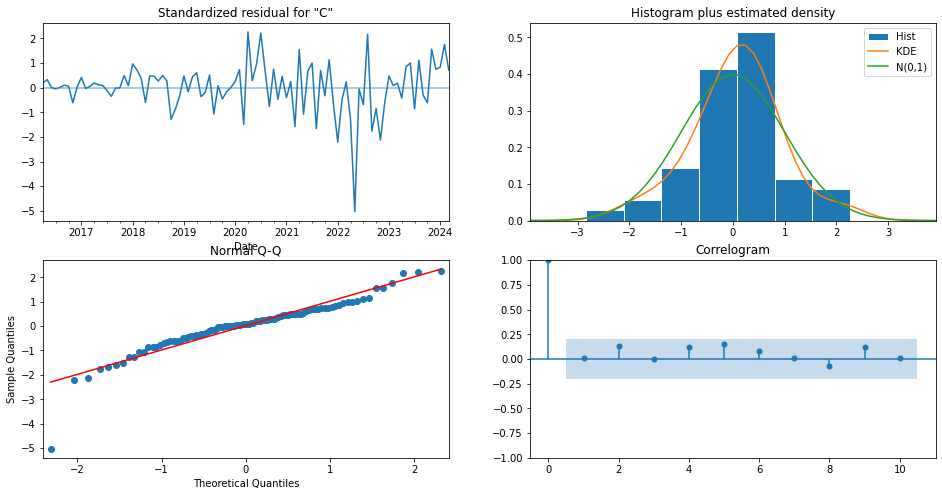

In [82]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

In [83]:
forcast = model.get_prediction(start=pd.to_datetime('2022-12-31'),dynamic=False)
pred_ci = forcast.conf_int()

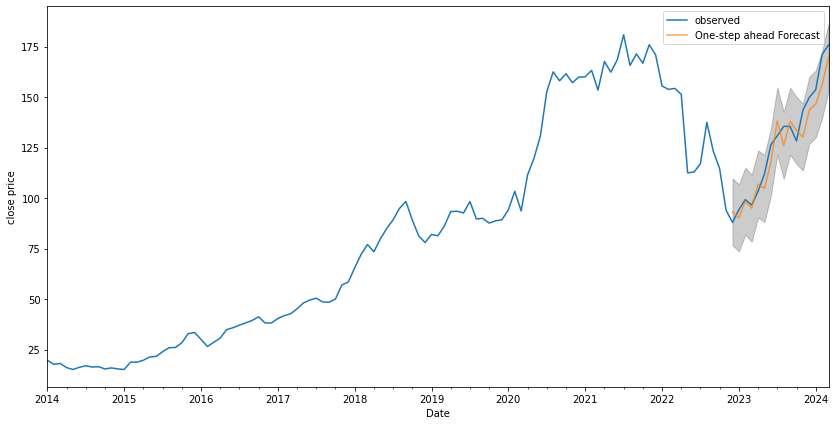

In [85]:
ax = monthly_mean['2014':].plot(label='observed')
forcast.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()


In [86]:
pred_mean = forcast.predicted_mean
actual = monthly_mean['2021-12-31':]
rmse = np.sqrt((pred_mean - actual) **2).mean()
print(rmse)

6.4371980309767425


# validating Forcasts

In [87]:
feature_forcast = model.get_forecast(steps=24)
predictions = feature_forcast.predicted_mean
ci = forcast.conf_int()


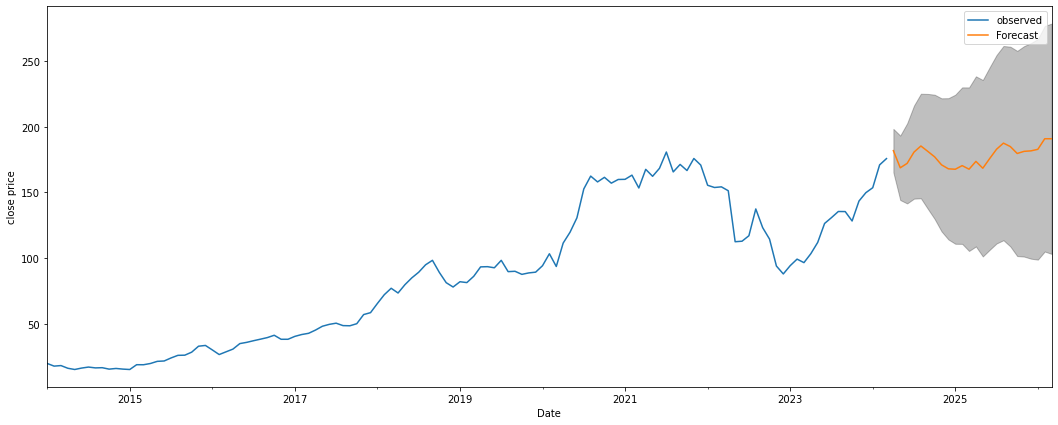

In [88]:
feature_forcast = model.get_forecast(steps=24)
pred_ci = feature_forcast.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(18, 7))
feature_forcast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

##### Our model has effectively captured the seasonal patterns in the close price data. However, as we extend our forecasts further into the future, it's expected that our confidence in the predicted values diminishes. This decrease in confidence is manifested through the widening of the confidence intervals generated by our model. Essentially, the uncertainty surrounding our predictions increases with the forecast horizon.